# Importovanie potrebných knižníc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from hiclass.metrics import precision as h_precision, recall as h_recall, f1 as h_f1
from sklearn.linear_model import LogisticRegression
import os

# V tejto časti prebieha predspracovanie dát pre ich ďalšie využitie v modeli

In [2]:
def preprocess_data(file_path):
    relevant_features = [
        'Vek',
        'Pohlavie',
        'Fajčenie',
        'Alkohol',
        'Hypertenzia',
        'Diabetes mellitus',
        'Kardiovaskulárne ochorenia',
        'Chronické respiračné ochorenia',
        'Renálne ochorenia',
        'Pečeňové ochorenia',
        'Onkologické ochorenia',
        'Imunosupresia',
        'Závažnosť priebehu ochorenia'
    ]

    data = pd.read_excel(file_path, usecols=relevant_features)
    # Odstránenie záznamov s chýbajúcou cieľovou premennou
    data=data.dropna(subset=['Závažnosť priebehu ochorenia'])
    # Konverzia kategórie "Pohlavie" na binárnu formu (one-hot encoding)
    data = pd.get_dummies(data, columns=['Pohlavie'], drop_first=True)

     # Vytvorenie nových cieľových premenných pre modelovanie úmrtnosti a závažnosti
    data["Mortality"] = data["Závažnosť priebehu ochorenia"].apply(lambda x: 1 if x == 3 else 0)
    data["Severity"] = data["Závažnosť priebehu ochorenia"].replace({3: np.nan, 1: 0, 2: 1})

    X = data.drop(columns=['Závažnosť priebehu ochorenia', 'Mortality', 'Severity'])
    y_mortality = data['Mortality']
    y_severity = data['Severity']
    y_true = data['Závažnosť priebehu ochorenia']

    return X, y_mortality, y_severity, y_true



# V tejto časti prebieha trénovanie modelu Logistic Regression s využitím pipeline a grid search optimalizácie

In [3]:

def train_logistic_regression(X, y, preprocessor, scoring='f1_weighted', random_state=42):


    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
       #('resampler', SMOTE(random_state=random_state)),  # V prípade potreby odstráňte komentáre (vykazuje horšie výsledky)
         ('classifier', LogisticRegression(
            random_state=random_state,
            class_weight='balanced',
        ))
    ])


    # Nastavenie grid search pre hľadanie najlepších hyperparametrov modelu
    param_grid = [
    {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [100, 500, 1000,5000],
        'classifier__class_weight': ['balanced', None]

    },
    {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__max_iter': [100, 500, 1000,5000],
        'classifier__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
         'classifier__class_weight': ['balanced', None  ]

    }
]

    # Spustenie grid search s 5-násobnou krížovou validáciou
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)
    return grid.best_estimator_


# V tejto časti prebieha vyhodnotenie predikcií modelu pomocou hierarchických metrík (knižnica hiclass).

In [4]:
def evaluate_predictions(y_true, y_pred):
 # Pomocná funkcia na konverziu tried do formátu vhodného pre hierarchické metriky
    def convert_to_hiclass_format(label):
        if label == 1:
            return ["0", "2"]
        elif label == 2:
            return ["0", "3"]
        elif label == 3:
            return ["1"]


    y_true_h = [convert_to_hiclass_format(label) for label in y_true]
    y_pred_h = [convert_to_hiclass_format(label) for label in y_pred]

    print("\n=== Hierarchical Metrics ===")
    print(f"H-Precision: {h_precision(y_true_h, y_pred_h):.4f}")
    print(f"H-Recall:    {h_recall(y_true_h, y_pred_h):.4f}")
    print(f"H-F1:        {h_f1(y_true_h, y_pred_h):.4f}")


# Táto funkcia vizualizuje dôležitosť príznakov (features) na základe koeficientov z logistickej regresie

In [5]:
def plot_feature_importance(pipeline, model_name="Model"):
        classifier = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor']
        coefficients = classifier.coef_[0]

        #Získavame mená príznakov po predspracovaní a čistíme
        feature_names = preprocessor.get_feature_names_out()
        cleaned_names = [name.split('__')[-1] for name in feature_names]

        importance_df = pd.DataFrame({
            'Feature': cleaned_names,
            'Coefficient': coefficients
        })


         #Vypočítavame absolútnu hodnotu koeficientov (čím väčšia, tým väčší vplyv) a zoradíme ich od najdôležitejších
        importance_df['Importance (Abs Coefficient)'] = importance_df['Coefficient'].abs()
        importance_df = importance_df.sort_values(by='Importance (Abs Coefficient)', ascending=False).reset_index(drop=True)

         #Nakreslíme horizontálny stĺpcový graf s príznakmi a ich dôležitosťou. Najdôležitejšie príznaky budú hore
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance (Abs Coefficient)'], color='skyblue')
        plt.xlabel('Importance (Absolute Coefficient Value)')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance based on Logistic Regression Coefficients\n({model_name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        return importance_df




# V tejto časti sa generujú a ukladajú hodnoty SHAP, ktoré vysvetľujú dôležitosť jednotlivých vstupných premenných pre rozhodovanie modelu. Tieto hodnoty pomáhajú interpretovať, ktoré atribúty mali najväčší vplyv na predpoveď modelu.
Použili sme len na najlepšie modely pre každú vlnu pandémie

In [6]:
def generate_and_save_shap_logistic(pipeline, X_train, feature_level, wave_id,
                                    shap_csv_filename=None,
                                    shap_image_filename=None):


    # Získame klasifikátor a predspracovanie z pipeline
    classifier = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']
    # Aplikujeme predspracovanie na trénovacie dáta
    X_train_transformed = preprocessor.transform(X_train)
    feature_names_raw = preprocessor.get_feature_names_out()

    # odstránenie prefixov scaler__, passthrough__)
    feature_names_clean = clean_feature_names(feature_names_raw)

    #Definícia maskera a SHAP explainer pre lineárny model
    masker = shap.maskers.Independent(X_train_transformed)
    explainer = shap.LinearExplainer(classifier, masker)
    shap_values = explainer.shap_values(X_train_transformed)
    if isinstance(shap_values, list):
         shap_values = shap_values[0]


    # Vytvorenie dátového rámca s SHAP hodnotami (pre dashboard)
    shap_df = pd.DataFrame(shap_values, columns=feature_names_clean, index=X_train.index)
    shap_df["level"] = feature_level
    shap_df["wave"] = wave_id
    new_shap_long = shap_df.melt(id_vars=["level", "wave"], var_name="feature", value_name="shap_value", ignore_index=False)


    # Ak existuje súbor s predchádzajúcimi SHAP hodnotami, načítame ho a vyfiltrujeme duplicitné záznamy
    other_data_df = pd.DataFrame()
    if os.path.exists(shap_csv_filename):
        existing_shap_df = pd.read_csv(shap_csv_filename)
        mask_to_keep = ~((existing_shap_df['level'] == feature_level) & (existing_shap_df['wave'] == wave_id))
        other_data_df = existing_shap_df[mask_to_keep]


    final_shap_df_to_save = pd.concat([other_data_df, new_shap_long], ignore_index=True)
    final_shap_df_to_save.to_csv(shap_csv_filename, index=False)

    # Ukladanie grafov
    if shap_image_filename:
        plt.figure()
        shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names_clean, show=False)
        if(feature_level=="mortality"):
            plt.title('SHAP Dôležitosť príznakov (Predikcia úmrtnosti) ')
        else:
            plt.title('SHAP Dôležitosť príznakov (Klasifikátor závažnosti u preživších)')


        plt.savefig(shap_image_filename, bbox_inches='tight')
        plt.show()
        plt.close()


# Funkcia na vymazanie prefixov z atribútov, ktoré boli pridané v časti prípravy dát

In [7]:
def clean_feature_names(feature_names):
    cleaned_names = []
    for name in feature_names:
        if name.startswith('scaler__'):
            cleaned_names.append(name.replace('scaler__', ''))
        elif name.startswith('passthrough__'):
            cleaned_names.append(name.replace('passthrough__', ''))
        else:
            cleaned_names.append(name)
    return cleaned_names


# V tejto časti prebieha hlavná príprava, trénovanie  a hodnotenie hierarchického modelu.
 Model je dvojúrovňový - najprv sa predpovedá pravdepodobnosť úmrtia (mortality), a ak pacient nebol predikovaný ako zomrel, pokračuje sa druhým modelom (severity), ktorý určuje závažnosť ochorenia u preživších.

# Prvá vlna pandémie

In [8]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/1vlna.xlsx')
feature_names = X.columns

# Rozdelenie dát na trénovaciu a testovaciu množinu so stratifikáciou podľa cieľovej premennej úmrtnosti (pretože dáta sú nevyvážené).
X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42, stratify=y_mortality
)

# Definícia predspracovania - normalizuje sa len vek, ostatné premenné zostávajú nezmenené
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])


# Trénovanie modelu pre predikciu úmrtnosti
mort_pipeline = train_logistic_regression(X_train, y_train_mort, preprocessor)

# Získanie predpovedí Out-of-Fold (OOF) pre trénovacie dáta pri použití modelu úmrtnosti
oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)

'''Tento blok kódu vykonáva filtrovanie trénovacích dát, pričom vyberáme len tie prípady, ktoré model úmrtnosti (mortality) predpovedal ako preživšie (0), a zároveň sa u týchto pacientov zaznamenáva úroveň závažnosti v skutočných údajoch (to znamená, že skutočne prežili a mali inú úroveň závažnosti ako smrť).'''
#Tieto dáta slúžia ako vstup pre druhý model – klasifikátor závažnosti.

survivor_mask_train_pred_oof = (oof_predictions == 0)
y_train_severity_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_mask

X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]

# Trénovanie modelu pre predikciu závažnosti na filtrovaných trénovacích dátach
severity_pipeline = train_logistic_regression(X_train_severity, y_train_severity, preprocessor)

# Predikcia umrtnosti (mortality) na testovacej množine
y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

# Príprava testovacích dát pre druhý model – len tí, ktorí boli predikovaní ako preživší.
X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)


# Ak existujú pacienti predikovaní ako preživší, aplikuje sa druhý model a zvýši sa predikovaná hodnota o 1, aby sa hodnoty mapovali späť na pôvodné označenie tried (1 alebo 2).
if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1

# Finalizácia predikcie:
# - pacienti predikovaní ako zomrelí (1. model) dostanú hodnotu 3
# - preživší dostanú predikovanú hodnotu závažnosti (1 alebo 2)
final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)

# Skutočné hodnoty pre testovaciu množinu
y_true_final = y_true.loc[X_test.index]

# Vyhodnotenie celkového výkonu hierarchického modelu
evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

=== Hierarchical Metrics ===
H-Precision: 0.7750
H-Recall:    0.8176
H-F1:        0.7957


# Úplne rovnaká štruktúra kódu je definovaná pre druhú, tretiu vlnu pandémie

# Druhá vlna pandémie

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


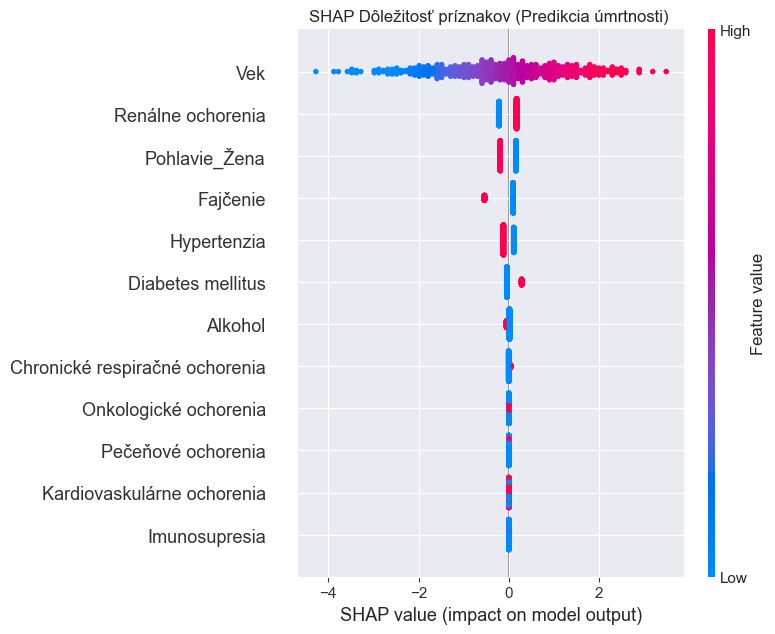

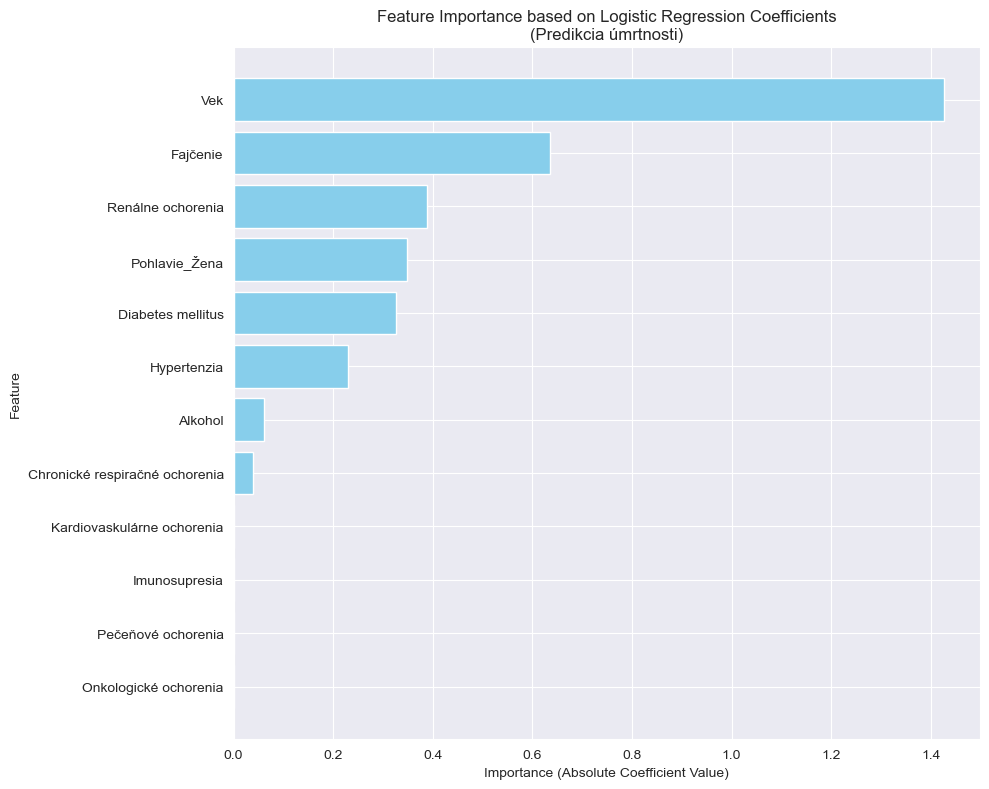

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


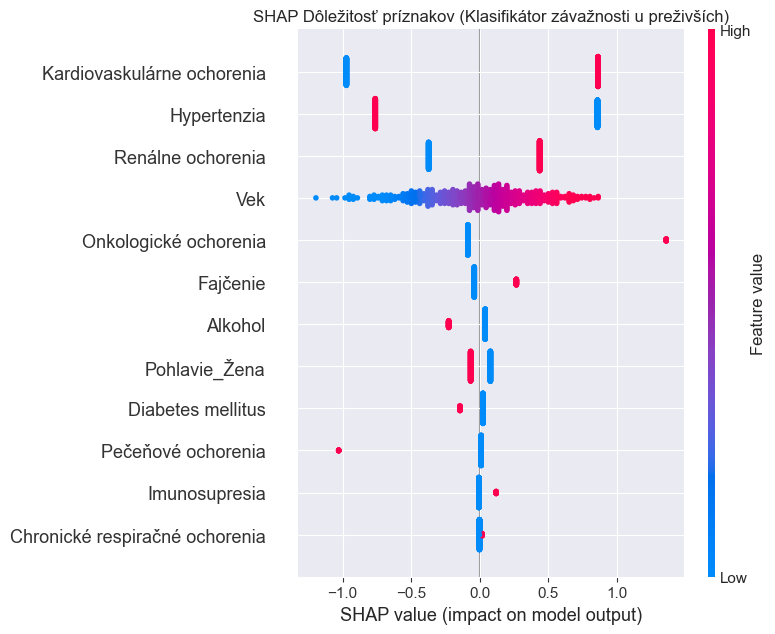

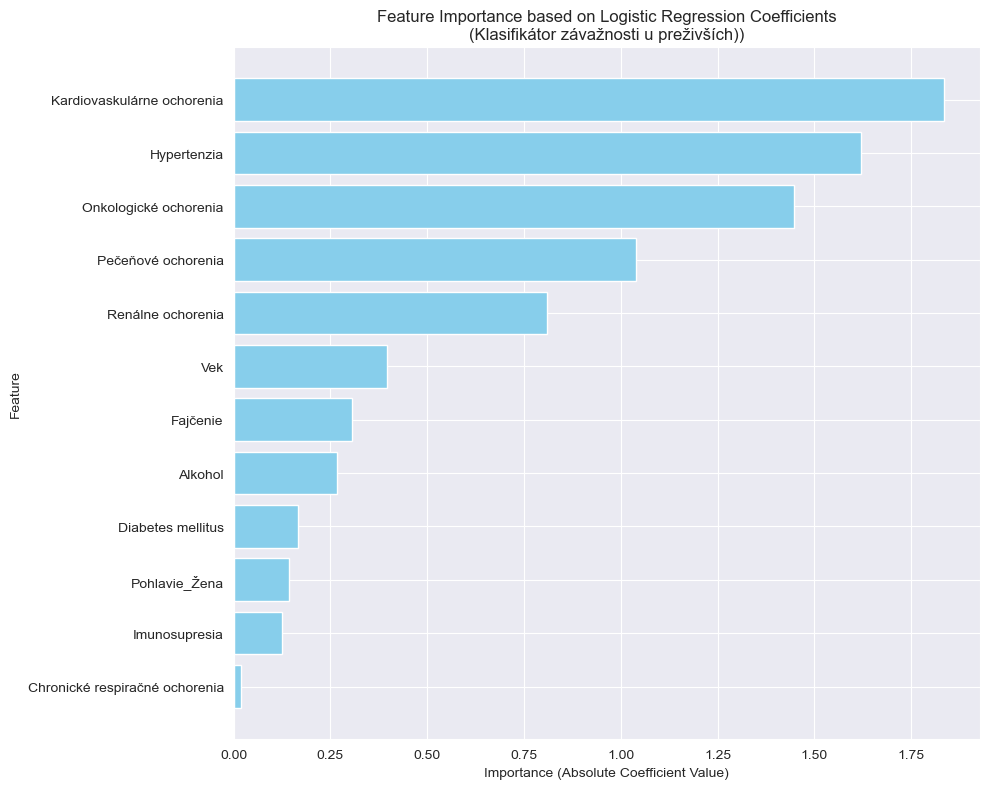


=== Hierarchical Metrics ===
H-Precision: 0.8147
H-Recall:    0.8621
H-F1:        0.8377


In [9]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/2vlna.xlsx')

X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42, stratify=y_mortality
)


preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])

mort_pipeline = train_logistic_regression(X_train, y_train_mort, preprocessor)
# Ak bol model úspešne natrénovaný, generujú sa SHAP hodnoty a ukladajú sa do súboru aj ako graf.
if mort_pipeline:
     generate_and_save_shap_logistic(
         pipeline=mort_pipeline,
         X_train=X_train,
         feature_level="mortality",
         wave_id=2,
        shap_csv_filename="shap_values.csv",
         shap_image_filename=f"shap_summary_mortality_wave2.png"
     )


#Zobrazí graf dôležitosti príznakov na základe koeficientov modelu úmrtnosti
mort_importance_df = plot_feature_importance(mort_pipeline, model_name="Predikcia úmrtnosti")



oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)
survivor_mask_train_pred_oof = (oof_predictions == 0)


y_train_severity_not_na_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_not_na_mask
X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]


severity_pipeline = train_logistic_regression(X_train_severity, y_train_severity, preprocessor)

# Ak bol model úspešne natrénovaný, generujú sa SHAP hodnoty a ukladajú sa do súboru aj ako graf.
if severity_pipeline:
    generate_and_save_shap_logistic(
          pipeline=severity_pipeline,
          X_train=X_train_severity,
          feature_level="severity",
          wave_id=2,
          shap_csv_filename="shap_values.csv",
          shap_image_filename=f"shap_summary_severity_wave2.png"
      )

#Zobrazí graf dôležitosti príznakov na základe koeficientov modelu závažnosti u preživších
severity_importance_df = plot_feature_importance(severity_pipeline, model_name="Klasifikátor závažnosti u preživších)")


y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)


if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1



final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)


y_true_final = y_true.loc[X_test.index]

evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))


# Tretia vlna pandémie

In [10]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/3vlna.xlsx')
feature_names = X.columns

X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42, stratify=y_mortality
)

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])

mort_pipeline = train_logistic_regression(X_train, y_train_mort, preprocessor)

oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)


survivor_mask_train_pred_oof = (oof_predictions == 0)
y_train_severity_not_na_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_not_na_mask

X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]


severity_pipeline = train_logistic_regression(X_train_severity, y_train_severity, preprocessor)

y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan) #zomrel-nan
if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1


final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)

y_true_final = y_true.loc[X_test.index]
evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

=== Hierarchical Metrics ===
H-Precision: 0.7784
H-Recall:    0.7995
H-F1:        0.7888


# Štvrtá vlna pandémie

Vzhľadom na nevyvážené dáta bolo pre štvrtú vlnu pandémie dodatočne pridaných niekoľko nových hyperparametrov pre GridSearch. Bez tohto prístupu modely ignorovali triedu „2 - preložený na iné oddelenie“, čo viedlo k nesprávnym predpovediam pre túto kategóriu

In [11]:
def train_logistic_regression_update(X, y, preprocessor, scoring='f1_weighted', random_state=42):

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
       #('resampler', SMOTE(random_state=random_state)),
         ('classifier', LogisticRegression(
            random_state=random_state,
            class_weight='balanced',

        ))

    ])

    param_grid = [
    {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [100, 500, 1000,5000],
        'classifier__class_weight': ['balanced', None, {0: 1, 1: 3}, {0: 1, 1: 5}]
    },
    {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__max_iter': [100, 500, 1000,5000],
        'classifier__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
         'classifier__class_weight': ['balanced', None, {0: 1, 1: 3}, {0: 1, 1: 5}]
    }
]

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X, y)

    print("Best parameters:", grid.best_params_)
    return grid.best_estimator_




Numeric Features: ['Vek']
Passthrough Features: ['Alkohol', 'Chronické respiračné ochorenia', 'Diabetes mellitus', 'Fajčenie', 'Hypertenzia', 'Imunosupresia', 'Kardiovaskulárne ochorenia', 'Onkologické ochorenia', 'Pečeňové ochorenia', 'Pohlavie_Žena', 'Renálne ochorenia']
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


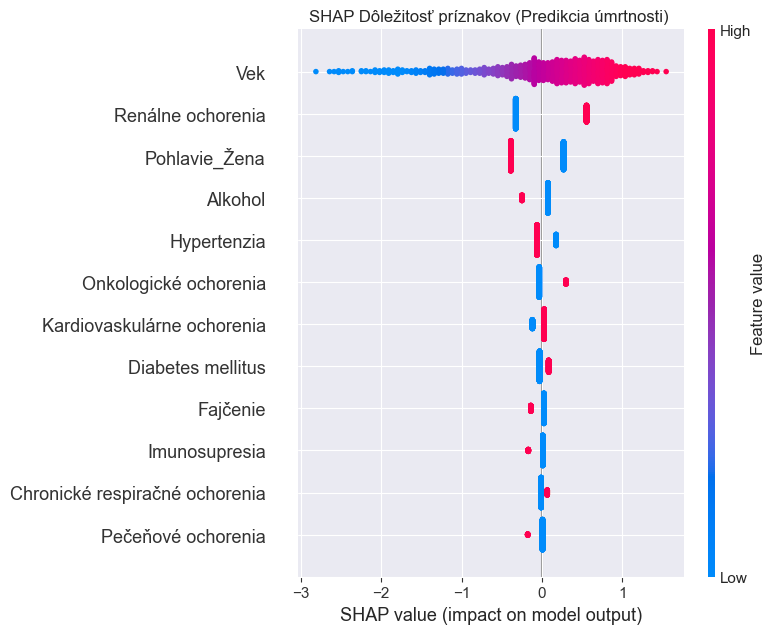

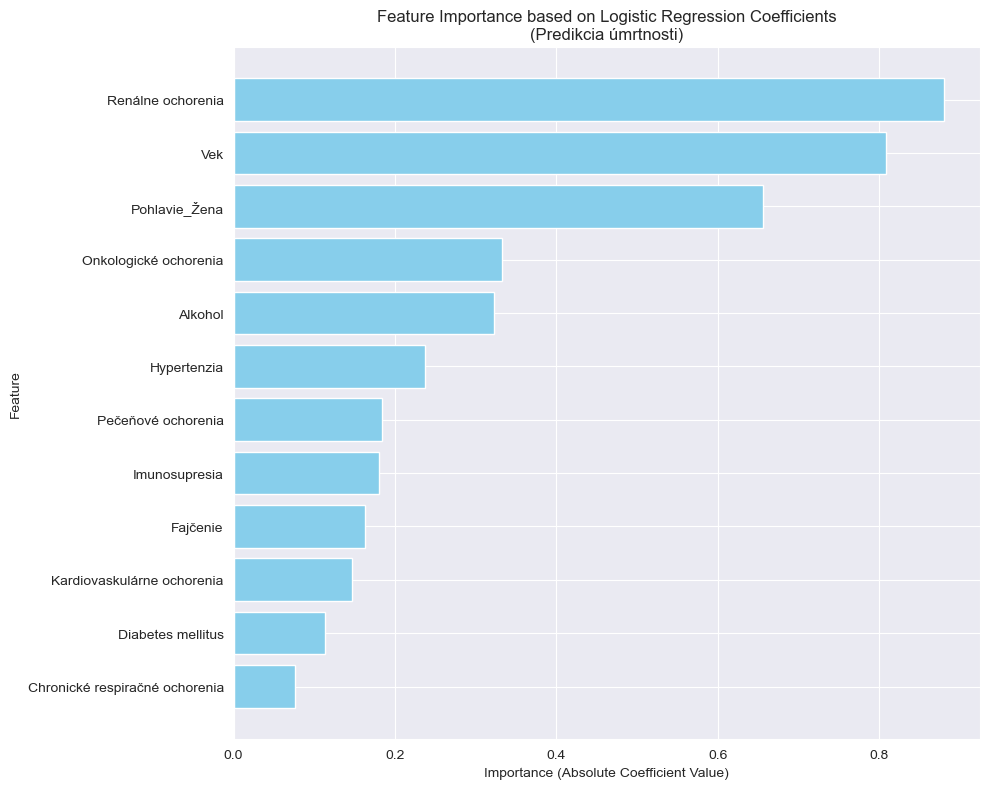

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier__l1_ratio': 0.4, 'classifier__max_iter': 100, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}


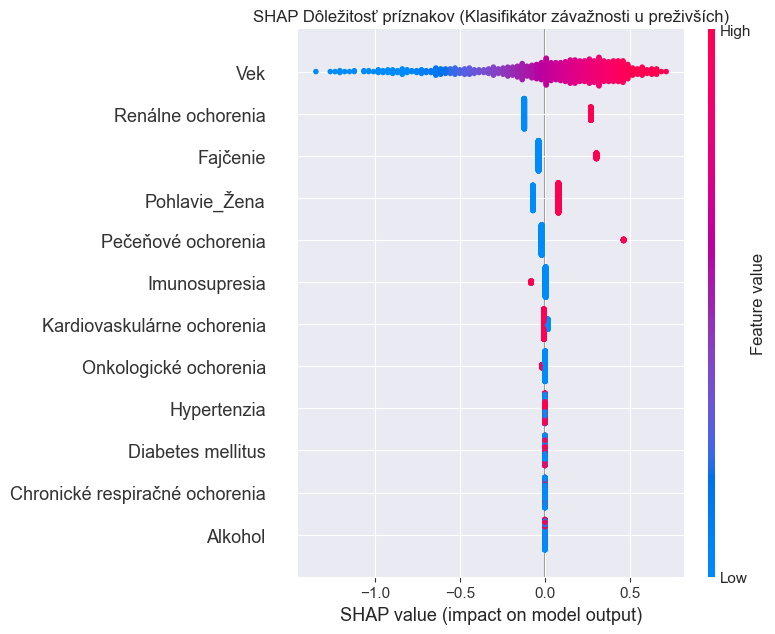

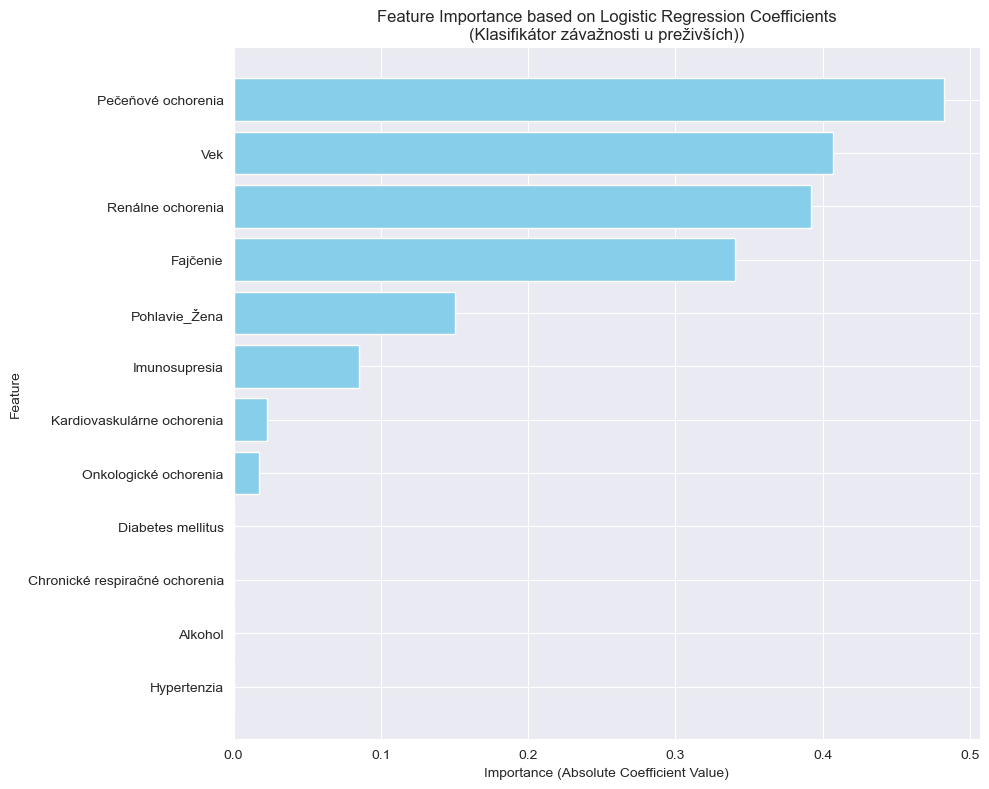


=== Hierarchical Metrics ===
H-Precision: 0.8096
H-Recall:    0.8395
H-F1:        0.8243


In [12]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/4vlna.xlsx')

feature_names = X.columns
numeric_features = ['Vek']
X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42
)

passthrough_features_index = X.columns.difference(numeric_features)
passthrough_features = passthrough_features_index.tolist()
print("Numeric Features:", numeric_features)
print("Passthrough Features:", passthrough_features)

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])

mort_pipeline = train_logistic_regression_update(X_train, y_train_mort, preprocessor)

if mort_pipeline:
     generate_and_save_shap_logistic(
         pipeline=mort_pipeline,
         X_train=X_train,
         feature_level="mortality",
         wave_id=4,
        shap_csv_filename="shap_values.csv",
         shap_image_filename=f"shap_summary_mortality_wave4.png"
     )



mort_importance_df = plot_feature_importance(mort_pipeline, model_name="Predikcia úmrtnosti")



oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)
survivor_mask_train_pred_oof = (oof_predictions == 0)


y_train_severity_not_na_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_not_na_mask
X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]


severity_pipeline = train_logistic_regression_update(X_train_severity, y_train_severity, preprocessor)



if severity_pipeline:
    generate_and_save_shap_logistic(
          pipeline=severity_pipeline,
          X_train=X_train_severity,
          feature_level="severity",
          wave_id=4,
          shap_csv_filename="shap_values.csv",
          shap_image_filename=f"shap_summary_severity_wave4.png"
      )

severity_importance_df = plot_feature_importance(severity_pipeline, model_name="Klasifikátor závažnosti u preživších)")



y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)


if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1


final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)


y_true_final = y_true.loc[X_test.index]

evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))

